## Hartree Fock Hydrogen Dissociation

Hartree Fock gives the best *single-configuration* description of the molecule

In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from pyscf import gto, scf, fci

def make_h2(d=1):
    mol = gto.Mole()
    mol.atom = f"""
    H 0 0 0
    H {d} 0 0
    """
    mol.basis = "sto-3g"
    mol.build()
    return mol

DIST = np.arange(0.25,5,0.1)
mol = make_h2()

In [2]:
#Hartree Fock Disassociation
class HF_Disc():
    def __init__(self):
        self.dist = DIST
        self.energies = []
        for d in tqdm(self.dist):
            d = np.round(d,2)
            # print("Running d =",d)
            mol = make_h2(d)
            mf = scf.RHF(mol)
            mf.verbose = 0
            mf.kernel()
            if d == 0.75:
                self.mf_bonding = mf
            if d == 4.95:
                self.mf_disc = mf
            self.energies += [mf.e_tot]        
        
hf = HF_Disc()

100%|███████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 58.17it/s]


converged SCF energy = -0.466581849557275


Text(4.1, -1.0331636991145507, 'Separate\nCalculation\nLimit')

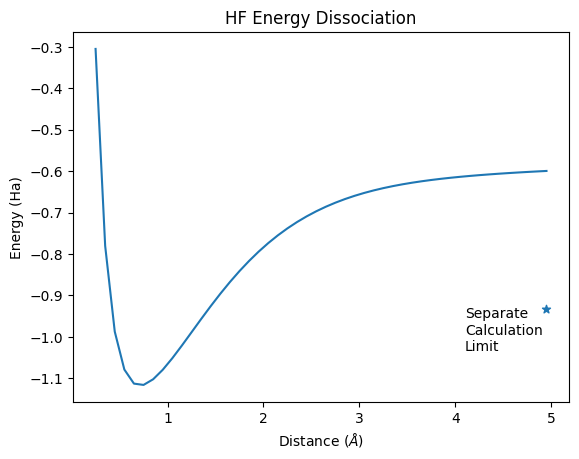

In [3]:
class HF_Exact_Disc():
    def __init__(self):
        mol = gto.Mole()
        mol.atom = f"""
        H 0 0 0
        """
        mol.basis = "sto-3g"
        mol.spin = 1
        mol.build()
        mf = scf.RHF(mol)
        mf.kernel()
        self.te = 2*mf.mol.intor("int1e_kin_sph")
        self.ve = 2*mf.mol.intor("int1e_nuc_sph")
        self.e_tot = 2*mf.energy_tot()
        self.mf = mf

twoh = HF_Exact_Disc()
import matplotlib.pyplot as plt
plt.plot(hf.dist,hf.energies)
plt.xlabel("Distance ($\AA$)")
plt.ylabel("Energy (Ha)")
plt.title("HF Energy Dissociation")
plt.scatter([4.95],[twoh.e_tot],marker="*")
# plt.annotate("Exact\nDissociation\nLimit",(4.1,twoh.e_tot-0.1))
plt.annotate("Separate\nCalculation\nLimit",(4.1,twoh.e_tot-0.1))

We see that HF is not *size consisent*, it does not converge to it's own dissociation limit if we had done separate calculations.

The reason for this is that a *single* configuration method it can *only* describe the H2 as *bonding*, whereas the actual dissociation limit is a *mixture* of *bonding* and *antibonding* configurations.

Before we move on to include these configurations though, we should check which parts of the HF energy are responsible for binding:

In [4]:
#It is worth seeing which component of the HF energy goes down while bonding:
n = "Bound"
mf = hf.mf_bonding
t = mf.mol.intor("int1e_kin_sph")
v = mf.mol.intor("int1e_nuc_sph")
dm = mf.make_rdm1()
te = np.einsum("ij,ij->",dm,t)
ve = np.einsum("ij,ij->",dm,v)
df = pd.DataFrame()
df.loc[n,"1/r Nuc"] = mf.energy_nuc()
df.loc[n,"T"] = te
df.loc[n,"V"] = ve
df.loc[n,"1/r Elec"] = mf.scf_summary["e2"]
n1 = n

n = "Dissociation"
n2 = n
df.loc[n,"1/r Nuc"] = 0
df.loc[n,"T"] = twoh.te[0][0]
df.loc[n,"V"] = twoh.ve[0][0]
df.loc[n,"1/r Elec"] = 0
df.loc["Bonding - Dissociation"] = df.loc[n1] - df.loc[n2]
df["sum"] = df.sum(axis=1)
df

,1/r Nuc,T,V,1/r Elec,sum
Bound,0.70557,1.198875,-3.693444,0.672848,-1.116151
Dissociation,0.00000,1.520064,-2.453227,0.000000,-0.933164
Bonding - Dissociation,0.70557,-0.321188,-1.240217,0.672848,-0.182988


Key observations:
1) The only negative component of the energy (the reason the electrons don't fly off into space) is the coulombic attraction (v)
2) The *kinetic* energy of the electrons (t) and the *coulombic attraction* to the nuclei (v) go down upon bonding
3) The *nuclear repulsion* (nuc) and *electron repulsion* (vhf) go up
4) The increase in nuclear and pauli repulsion is *greater* than the decrease in coulombic attraction (v)
5) --> The decrease in kinetic energy is *vital* for chemical bonding!

In [5]:
#Compare the two-orbital to one-orbital picture:
n = "Two-Orbital Dissociation"
import pandas as pd
df = pd.DataFrame()
df.loc[n,"1/r Nuc"] = 0
df.loc[n,"T"] = twoh.te[0][0]
df.loc[n,"V"] = twoh.ve[0][0]
df.loc[n,"1/r Elec"] = 0

n = "One-Orbital Dissociation"
mf = hf.mf_disc
t = mf.mol.intor("int1e_kin_sph")
v = mf.mol.intor("int1e_nuc_sph")
dm = mf.make_rdm1()
te = np.einsum("ij,ij->",dm,t)
ve = np.einsum("ij,ij->",dm,v)
df.loc[n,"1/r Nuc"] = mf.energy_nuc()
df.loc[n,"T"] = te
df.loc[n,"V"] = ve
df.loc[n,"1/r Elec"] = mf.scf_summary["e2"]
df

,1/r Nuc,T,V,1/r Elec
Two-Orbital Dissociation,0.000000,1.520064,-2.453227,0.000000
One-Orbital Dissociation,0.106904,1.519613,-2.666810,0.440699


## Full Configuration Interaction

Full configuration interaction gives the *exact* solution within the basis. It achieves this by averaging over the bonding and antibonding configurations. Let's see this below!

In [6]:
#FCI at bonding geometry (0.75 A)
from pyscf import fci
mol = make_h2()
fc = fci.FCI(hf.mf_bonding)
# fc = fci.FCI(hf.mf_)
fci_energy, fci_vect = fc.kernel()

#Let's focus on the main difference -- we have a FCI *vector*, this is the wave function!
#For efficiency it is stored as a vector
fci_vect

FCIvector([[ 9.93413926e-01, -6.93889390e-17],
           [ 2.84067279e-18, -1.14580851e-01]])

In [7]:
def interpret_fci_vec(ci):
    from pyscf.fci import cistring
    na,nb = 1,1
    ncas = 2
    for i,c in enumerate(ci.ravel()):
        a_addr,b_addr = np.unravel_index(i, ci.shape)
        astr = cistring.addrs2str(ncas,na,[a_addr])
        bstr = cistring.addrs2str(ncas,nb,[b_addr])
        a_occslst = cistring._strs2occslst(astr,ncas)
        b_occslst = cistring._strs2occslst(bstr,ncas)
        occs = np.zeros(ncas)
        occs[a_occslst] += 1
        occs[b_occslst] += 1
        print(np.round(c,3),occs)

#As is seen, we have the expected four configurations:
#ab 0, a b, b a, and 0 ab
#a and b are alpha and beta electrons
interpret_fci_vec(fci_vect)

#Note that the weights of the FCI vectors (ab) and (ba) are very small
#This is because they are actually disallowed by *symmetry*, because we ar
#So really there are just two configurations -- the bonding and antibonding configurations

#We can even see that the fci vec is normalized across these configurations:
print("Normalization:",np.round((fci_vect**2).sum(),4))

0.993 [2. 0.]
-0.0 [1. 1.]
0.0 [1. 1.]
-0.115 [0. 2.]
Normalization: 1.0


So we see that FCI allows us to describe H2 as a mix of a *bonding* and an *antibonding* configuration, let's see how these change as a function of the distance:

In [8]:
class FCI_Disc():
    def __init__(self):
        self.dist = DIST
        self.energies = []
        self.civecs = []
        for d in tqdm(self.dist):
            d = np.round(d,2)
            # print("Running d =",d)
            mol = make_h2(d)
            mf = scf.RHF(mol)
            mf.verbose = 0
            mf.kernel()
            fc = fci.FCI(mf)
            fci_energy, fci_vect = fc.kernel()
            if d == 0.75:
                self.fci_bonding = fc
            if d == 4.95:
                self.fci_disc = fc
            self.energies += [fci_energy]
            self.civecs += [fci_vect]

    def plot_c(self):
        import matplotlib.pyplot as plt


100%|███████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 57.62it/s]

converged SCF energy = -0.466581849557275


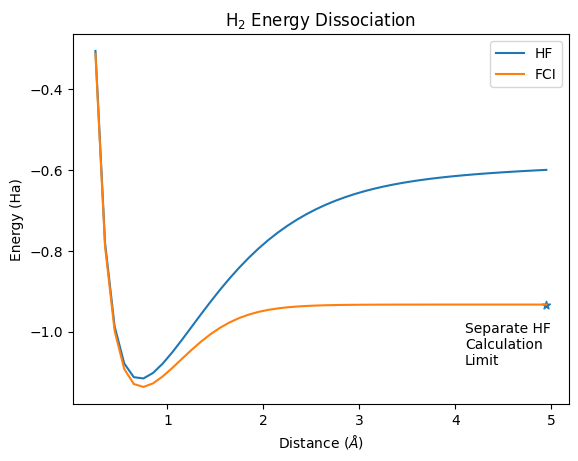

In [9]:
import matplotlib.pyplot as plt
plt.plot(hf.dist,hf.energies,label="HF")
plt.xlabel("Distance ($\AA$)")
plt.ylabel("Energy (Ha)")

obj = FCI_Disc()
twoh = HF_Exact_Disc()
import matplotlib.pyplot as plt
plt.plot(DIST,obj.energies,label="FCI")
plt.xlabel("Distance ($\AA$)")
plt.ylabel("Energy (Ha)")
plt.title("H$_2$ Energy Dissociation")
plt.scatter([4.95],[twoh.e_tot],marker="*")
# plt.annotate("Exact\nDissociation\nLimit",(4.1,twoh.e_tot-0.1))
plt.annotate("Separate HF \nCalculation\nLimit",(4.1,twoh.e_tot-0.15))
plt.legend()

Text(0.5, 1.0, 'H$_2$ Bonding/Antibonding Character')

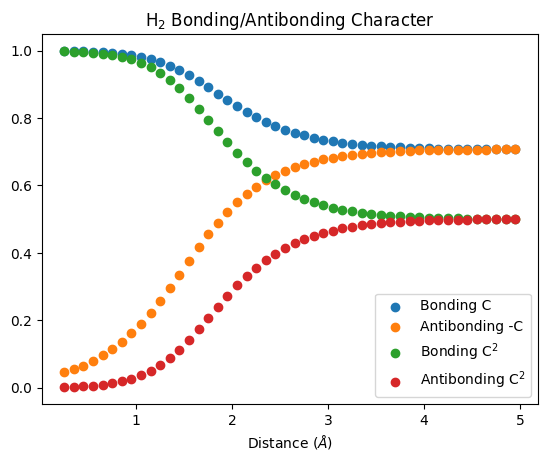

In [10]:
b = [obj.civecs[i].ravel()[0] for i in range(len(obj.civecs))]
ab = [obj.civecs[i].ravel()[-1] for i in range(len(obj.civecs))]
b = np.abs(b)
ab = np.abs(ab)
p_b = b**2
p_ab = ab**2
plt.scatter(DIST,b,label="Bonding C")
plt.scatter(DIST,ab,label="Antibonding -C")
plt.scatter(DIST,p_b,label="Bonding C$^2$")
plt.scatter(DIST,p_ab,label="Antibonding C$^2$")
plt.legend(loc="lower right")
plt.xlabel("Distance ($\AA$)")
plt.title("H$_2$ Bonding/Antibonding Character")

## Approximations to FCI: DFT, MP2 CCSD

In [11]:
class DFT_Disc():
    def __init__(self):
        self.dist = DIST
        self.energies = []
        for d in tqdm(self.dist):
            d = np.round(d,2)
            # print("Running d =",d)
            mol = make_h2(d)
            mf = scf.RKS(mol)
            mf.xc = "b3lyp"
            mf.verbose = 0
            mf.kernel()
            if d == 0.75:
                self.mf_bonding = mf
            if d == 4.95:
                self.mf_disc = mf
            self.energies += [mf.e_tot]

dft = DFT_Disc()

  0%|                                                                                        | 0/48 [00:00<?, ?it/s]/home/king1305/Apps/pyscf/pyscf/dft/libxc.py:512: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '
100%|███████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.86it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 57.53it/s]

converged SCF energy = -0.466581849557275


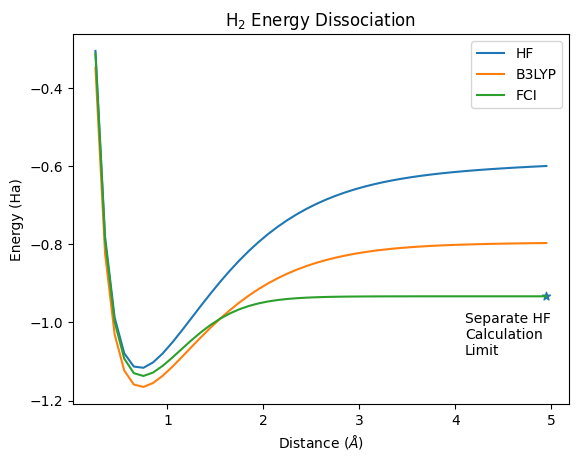

In [12]:
import matplotlib.pyplot as plt
plt.plot(hf.dist,hf.energies,label="HF")
plt.xlabel("Distance ($\AA$)")
plt.ylabel("Energy (Ha)")

plt.plot(dft.dist,dft.energies,label="B3LYP")
plt.xlabel("Distance ($\AA$)")
plt.ylabel("Energy (Ha)")

obj = FCI_Disc()
twoh = HF_Exact_Disc()
import matplotlib.pyplot as plt
plt.plot(DIST,obj.energies,label="FCI")
plt.xlabel("Distance ($\AA$)")
plt.ylabel("Energy (Ha)")
plt.title("H$_2$ Energy Dissociation")
plt.scatter([4.95],[twoh.e_tot],marker="*")
# plt.annotate("Exact\nDissociation\nLimit",(4.1,twoh.e_tot-0.1))
plt.annotate("Separate HF \nCalculation\nLimit",(4.1,twoh.e_tot-0.15))
plt.legend()

In [13]:
from pyscf import gto, scf, cc

class CC_Disc():
    def __init__(self):
        self.dist = DIST
        self.energies = []
        for d in tqdm(self.dist):
            d = np.round(d,2)
            # print("Running d =",d)
            mol = make_h2(d)
            mf = scf.RHF(mol)
            mf.verbose = 0
            mf.kernel()
            mycc = cc.CCSD(mf)
            mycc.verbose = 0
            mycc.kernel()
            if d == 0.75:
                self.mf_bonding = mf
            if d == 4.95:
                self.mf_disc = mf
            self.energies += [mycc.e_tot]

ccsd = CC_Disc()

100%|███████████████████████████████████████████████████████████████████████████████| 48/48 [00:07<00:00,  6.69it/s]


converged SCF energy = -0.466581849557275


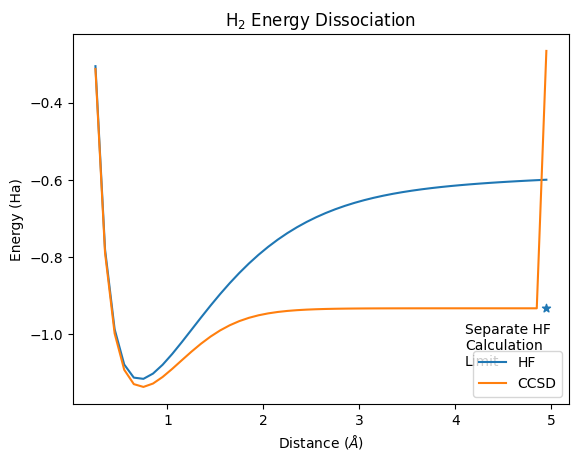

In [18]:
import matplotlib.pyplot as plt
plt.plot(hf.dist,hf.energies,label="HF")
plt.xlabel("Distance ($\AA$)")
plt.ylabel("Energy (Ha)")

# plt.plot(ccsd.dist[:-1],ccsd.energies[:-1],label="CCSD")
plt.plot(ccsd.dist,ccsd.energies,label="CCSD")
plt.xlabel("Distance ($\AA$)")
plt.ylabel("Energy (Ha)")

# obj = FCI_Disc()
twoh = HF_Exact_Disc()
import matplotlib.pyplot as plt
# plt.plot(DIST,obj.energies,label="FCI")
plt.xlabel("Distance ($\AA$)")
plt.ylabel("Energy (Ha)")
plt.title("H$_2$ Energy Dissociation")
plt.scatter([4.95],[twoh.e_tot],marker="*")
# plt.annotate("Exact\nDissociation\nLimit",(4.1,twoh.e_tot-0.1))
plt.annotate("Separate HF \nCalculation\nLimit",(4.1,twoh.e_tot-0.15))
plt.legend()

In [15]:
from pyscf import gto, scf, mp

class MP2_Disc():
    def __init__(self):
        self.dist = DIST
        self.energies = []
        for d in tqdm(self.dist):
            d = np.round(d,2)
            # print("Running d =",d)
            mol = make_h2(d)
            mf = scf.RHF(mol)
            mf.verbose = 0
            mf.kernel()
            mycc = mp.MP2(mf)
            mycc.verbose = 0
            mycc.kernel()
            if d == 0.75:
                self.mf_bonding = mf
            if d == 4.95:
                self.mf_disc = mf
            self.energies += [mycc.e_tot]

mp2 = MP2_Disc()

100%|███████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 61.20it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 61.06it/s]

converged SCF energy = -0.466581849557275


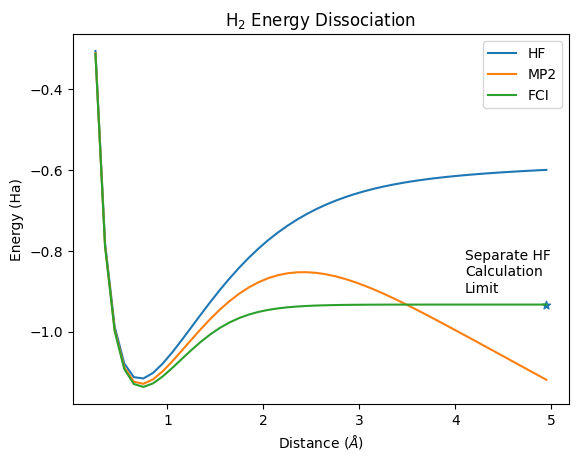

In [17]:
import matplotlib.pyplot as plt
plt.plot(hf.dist,hf.energies,label="HF")
plt.xlabel("Distance ($\AA$)")
plt.ylabel("Energy (Ha)")

plt.plot(mp2.dist,mp2.energies,label="MP2")
plt.xlabel("Distance ($\AA$)")
plt.ylabel("Energy (Ha)")

obj = FCI_Disc()
twoh = HF_Exact_Disc()
import matplotlib.pyplot as plt
plt.plot(DIST,obj.energies,label="FCI")
plt.xlabel("Distance ($\AA$)")
plt.ylabel("Energy (Ha)")
plt.title("H$_2$ Energy Dissociation")
plt.scatter([4.95],[twoh.e_tot],marker="*")
# plt.annotate("Exact\nDissociation\nLimit",(4.1,twoh.e_tot-0.1))
plt.annotate("Separate HF \nCalculation\nLimit",(4.1,twoh.e_tot+0.03))
plt.legend()